# Load the data

In [1]:
import torch
import datasets
import numpy as np
import pandas as pd

In [2]:
datadir_camembert = "camembert-tokens.datasets"
datadir_flaubert = "flaubert-tokens.datasets"

In [3]:
tokenized_datasets_camembert = datasets.load_from_disk(datadir_camembert)
tokenized_datasets_flaubert = datasets.load_from_disk(datadir_flaubert)

In [4]:
test_dataset_camembert = tokenized_datasets_camembert["test"].select(range(50))
test_dataset_flaubert = tokenized_datasets_flaubert["test"].select(range(50))

# Load the models

In [33]:
n = input()
print("number of epochs for the fine tuned model : {}".format(n))

number of epochs for the fine tuned model : 1


In [34]:
from transformers import FlaubertForSequenceClassification
from transformers import CamembertForSequenceClassification

# flaubert
model_name_fb = './flaubert_base_cased_' + n
model_flaubert = FlaubertForSequenceClassification.from_pretrained(model_name_fb,
                                                                   num_labels=2,
                                                                   output_attentions=False,
                                                                   output_hidden_states=True)

# camembert
model_name_cb = './camembert_base_' + n
model_camembert = CamembertForSequenceClassification.from_pretrained(model_name_cb,
                                                                     num_labels=2,
                                                                     output_attentions=False,
                                                                     output_hidden_states=True)

In [35]:
model_camembert.eval()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [36]:
model_flaubert.eval()

FlaubertForSequenceClassification(
  (transformer): FlaubertModel(
    (position_embeddings): Embedding(512, 768)
    (embeddings): Embedding(68729, 768, padding_idx=2)
    (layer_norm_emb): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0): MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
        (k_lin): Linear(in_features=768, out_features=768, bias=True)
        (v_lin): Linear(in_features=768, out_features=768, bias=True)
        (out_lin): Linear(in_features=768, out_features=768, bias=True)
      )
      (1): MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
        (k_lin): Linear(in_features=768, out_features=768, bias=True)
        (v_lin): Linear(in_features=768, out_features=768, bias=True)
        (out_lin): Linear(in_features=768, out_features=768, bias=True)
      )
      (2): MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_feature

# Cosine study

In [12]:
def mat_sim(layer, attention_mask):
    """
    :param layer: torch.tensor of the shape (1 (batch_size) , nb_tokens , 768)
                  hidden states of the transformers
    :param attention_mask: torch.tensor of the shape (1, nb_tokens)

    :return: res : the similarity matrix of the shape (k,k)
             k   : the numer of non-pad tokens in the sentence we are dealing with
    """

    # with the dataset we are nb_token = 512
    nb_token = layer.shape[1]

    l = []
    k = 0
    for i in range(nb_token):
        if attention_mask[i] == 1:
            '''
            check of the padding
            '''
            l.append(list(layer[0, i, :].detach().numpy()))
            k += 1
        else:
            '''
            stop the loop
            '''
            break

    l = np.array(l).T

    res = np.zeros((k, k))

    for i in range(k):
        for j in range(k):
            # cosine calculus
            res[i, j] = np.dot(l[:, i], l[:, j]) / (np.linalg.norm(l[:, i]) * np.linalg.norm(l[:, j]))

    return res, k

In [13]:
def construct_df_dist(datasets,
                      type_model: str = "flaubert"):
    """
    :param datasets: one of the tokenized dataset (FlauBERT or CamemBERT)
    :param type_model: choose between FlauBERT or CamemBERT

    :return: df_dist : - a dataframe with 13 columns.
                       - on each columns corresponds to a layer in the transformer a nd
                         the values corresponds to the cosine similarities within each sentences

             df_var : - a dataframe with 13 columns
                      - on each columns corresponds to a layer in the transformer and
                        each value corresponds to the variance of the values of the cosine similarity within each layer
    """

    nb_layer = 13

    mat_var = {}

    mat_dist = {}

    for i in range(nb_layer):
        mat_dist[i] = []
        mat_var[i] = []

    for data in datasets:

        # store the output
        output = None

        if type_model == "flaubert":
            output = model_flaubert(attention_mask=torch.tensor([data["attention_mask"]]),
                                    input_ids=torch.tensor([data["input_ids"]])
                                    )
        else:
            output = model_camembert(attention_mask=torch.tensor([data["attention_mask"]]),
                                     input_ids=torch.tensor([data["input_ids"]]))

        # we store the hidden_states
        hidden_states = output.hidden_states

        for i in range(nb_layer):
            curr_layer = hidden_states[i]
            mat_cos, n = mat_sim(curr_layer, data["attention_mask"])  # cosine matrice

            l = list(mat_cos[np.triu_indices(n, k=1)])

            mat_var[i].append(np.var(l))
            mat_dist[i] += l

    df_var = pd.DataFrame(mat_var)
    df_dist = pd.DataFrame(mat_dist)

    new_col = ['layer' + "_" + str(i) for i in df_var.columns]

    d = dict(zip(df_var.columns, new_col))

    df_var.rename(columns=d,
                  inplace=True)

    df_dist.rename(columns=d,
                   inplace=True)

    return df_dist, df_var


In [14]:
def df_cos(df_dist):
    """
    :param df_dist: the df_dist we return on the previous function.
    :return: a dataframe with the good format for a plot with legend on seaborn
    """
    dist_vect = []
    legend_vect = []

    for column in df_dist:
        dist_vect += list(df_dist[column].values)
        legend_vect += [column] * len(df_dist[column])

    df = pd.DataFrame({"layer": legend_vect, "cosines": dist_vect})

    return df

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

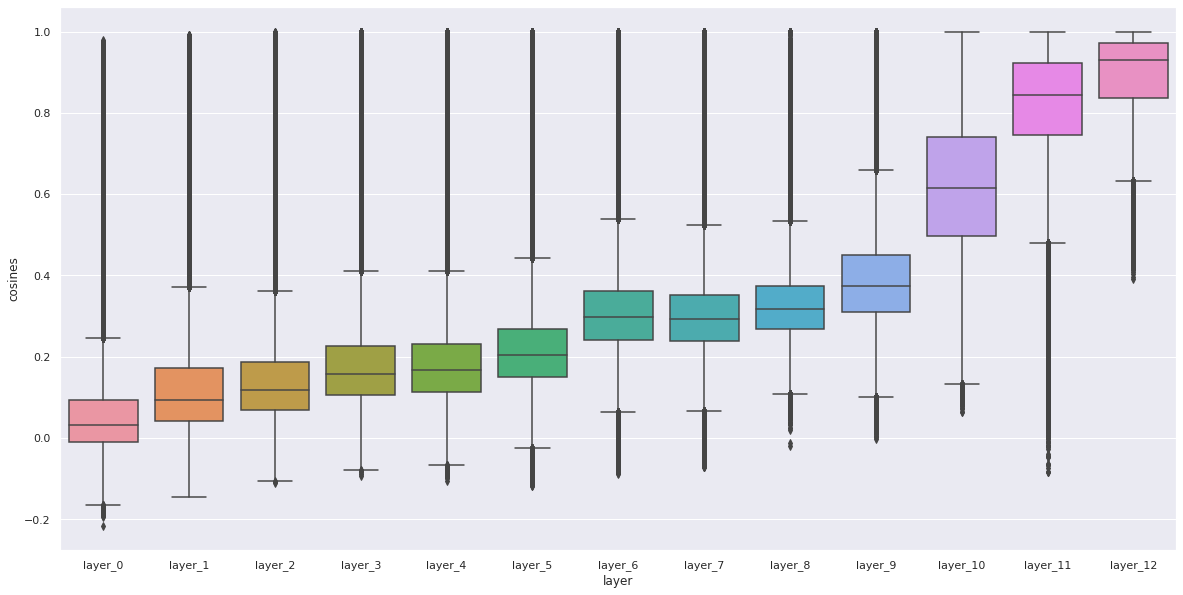

In [16]:
figure = plt.figure(figsize=(20, 10))
# work on flaubert
df_dist, df_var = construct_df_dist(test_dataset_flaubert)
cos_values = df_cos(df_dist)
fig = sns.boxplot(x="layer", y="cosines", data=cos_values)

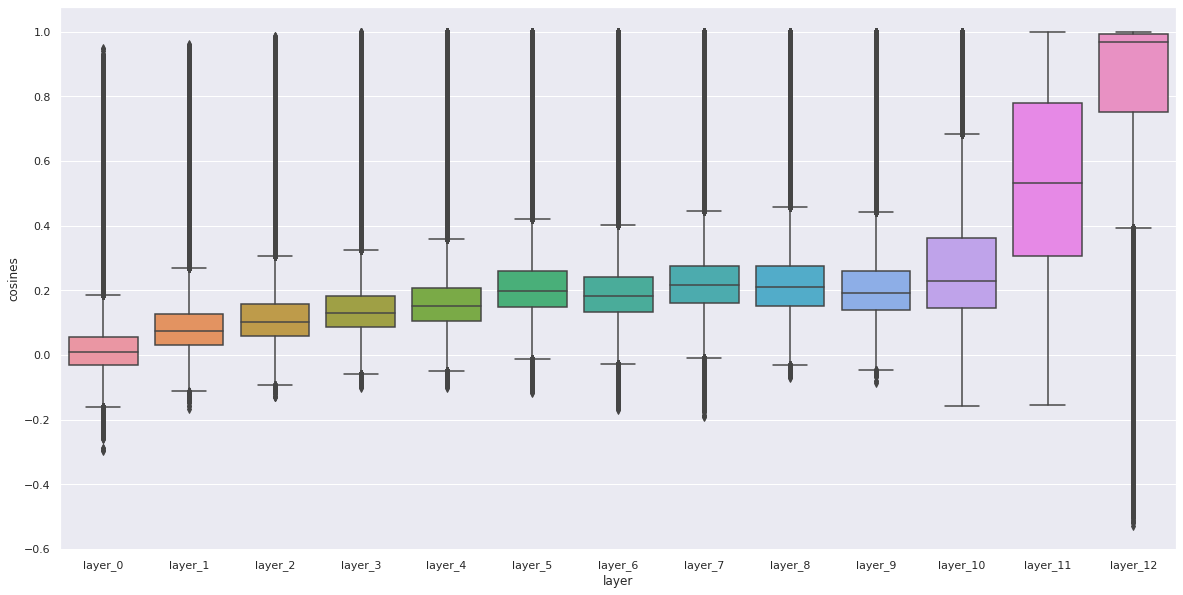

In [17]:
# work on camembert
df_dist, df_var = construct_df_dist(test_dataset_camembert, type_model="camembert")
cos_values = df_cos(df_dist)
figure = plt.figure(figsize=(20, 10))
fig = sns.boxplot(x="layer", y="cosines", data=cos_values)

# Vcov study

In [18]:
def cov_emb(layer, attention_mask):
    """
    :param layer: torch.tensor of the shape (1 (batch_size) , nb_tokens , 768)
                  hidden states of the transformers
    :param attention_mask: torch.tensor of the shape (1, nb_tokens)

    :return: the vcov matrix of the embeddings, on the layer
    """
    nb_tok = layer.shape[1]

    l = []

    for i in range(nb_tok):
        if attention_mask[i] == 1:
            l.append(list(layer[0, i, :].detach().numpy()))
        else:
            # if we encounter a padding all the rest is padding
            break

    l = np.array(l).T

    return (np.cov(l))

In [19]:
def df_trace_vcov(dataset,
                  type_model: str = "flaubert",
                  nb_layer: int = 13):
    """
    :param dataset: one of the dataset provided
    :param type_model: choose between FlauBERT or CamemBERT
    :param nb_layer: the number of layer in the model we want to use
                     (this parameter is a bit useless considering both models have 13 layers)

    :return: df: a pandas dataframe with nb_layer columns each columns corresponding to a layer of the model
                 the values within each columns correspond to the trace of the vcov (calculated above) for different layer
    """
    legend_vect = []
    trace_vect = []

    for data in dataset:
        output = None

        # output of the model
        if type_model == "flaubert":
            output = model_flaubert(attention_mask=torch.tensor([data["attention_mask"]]),
                                    input_ids=torch.tensor([data["input_ids"]])
                                    )
        else:
            output = model_camembert(attention_mask=torch.tensor([data["attention_mask"]]),
                                     input_ids=torch.tensor([data["input_ids"]]))

        # hidden_states of the transformers
        hidden_states = output.hidden_states

        for i in range(nb_layer):
            curr_layer = hidden_states[i]
            lay = "layer_" + str(i)
            buff = np.trace(cov_emb(curr_layer, data["attention_mask"]))
            legend_vect.append(lay)
            trace_vect.append(buff)

    df = pd.DataFrame({"layer": legend_vect,
                       "trace": trace_vect})

    return df


In [20]:
test_dataset_camembert = tokenized_datasets_camembert["test"].select(range(100))
test_dataset_flaubert = tokenized_datasets_flaubert["test"].select(range(100))

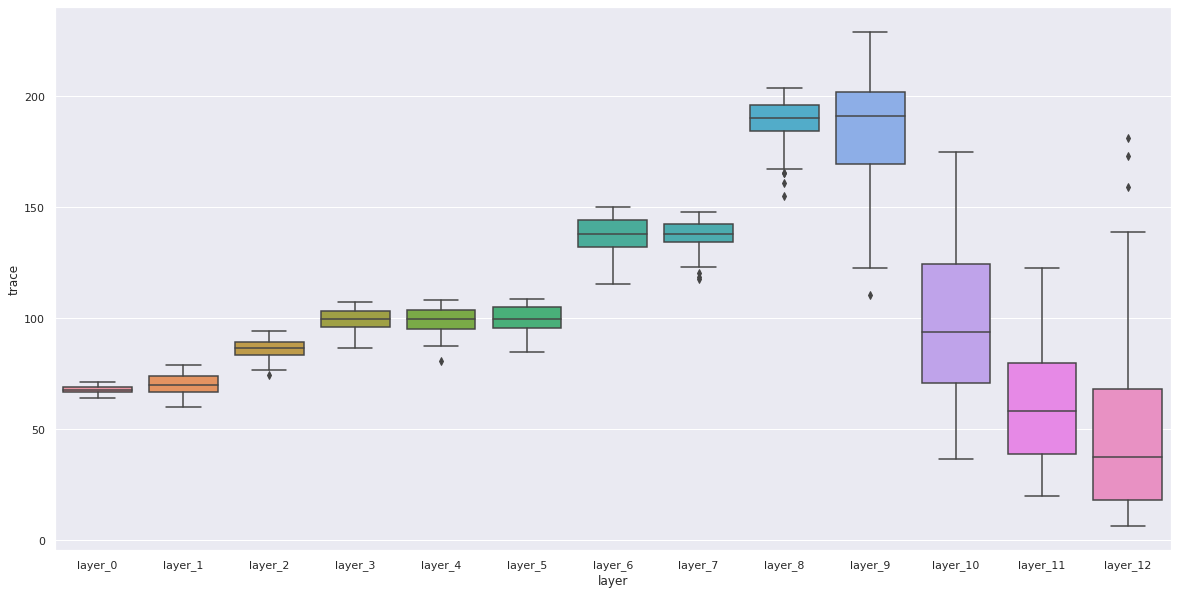

In [21]:
# work on flaubert
figure = plt.figure(figsize=(20, 10))
df = df_trace_vcov(test_dataset_flaubert)
fig = sns.boxplot(x="layer", y="trace", data=df)

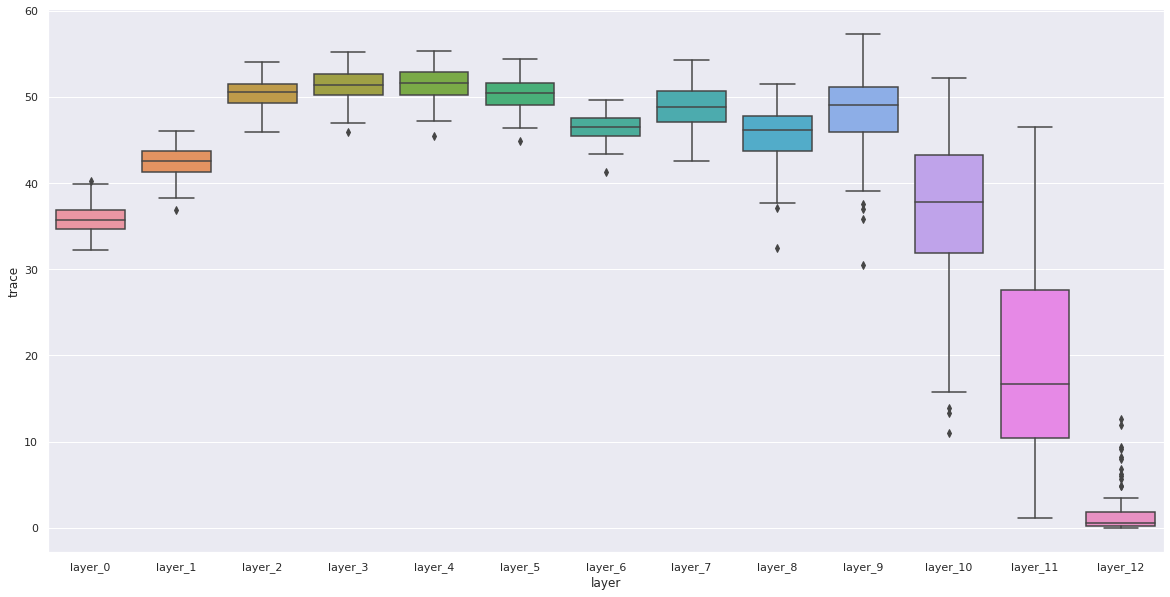

In [22]:
# work on camembert
figure = plt.figure(figsize=(20, 10))
df = df_trace_vcov(test_dataset_camembert, type_model="camembert")
fig = sns.boxplot(x="layer", y="trace", data=df)

# Erank study

In [37]:
def erank_metric(W):
    #   --> we assume that nrow(W) > ncol(W)
    #   --> decomposition of the matrix in singular value
    u, s, vh = np.linalg.svd(W, full_matrices=True)
    #   s --> singular values of the matrix W

    s1 = np.sum(s)  # sum of the singular values

    k = s / s1
    k = k * np.log(k)

    return (np.exp(-sum(k)))

In [38]:
def calculus_erank(dataset,
                   type_model: str = "flaubert",
                   nb_tok: int = 512):
    """
    :param nb_tok: number of tokens on each sentence (padded sentences)
    :return: pandas dataframe of the values of erank on each layer
             calculated on multiple sentences
    """
    layer_W = {}

    for i in range(13):
        layer_W[i + 1] = []

    for data in dataset:
        output = None

        # output of the model
        if type_model == "flaubert":
            output = model_flaubert(attention_mask=torch.tensor([data["attention_mask"]]),
                                    input_ids=torch.tensor([data["input_ids"]])
                                    )
        else:
            output = model_camembert(attention_mask=torch.tensor([data["attention_mask"]]),
                                     input_ids=torch.tensor([data["input_ids"]]))

        # hidden_states of the transformers
        hidden_states = output.hidden_states

        for i in range(13):
            curr_layer = hidden_states[i][0]  #   --> current layer.

            for t in range(nb_tok):
                if data["attention_mask"][t] == 1:
                    emb_tok = list(curr_layer[t, :].detach().numpy())
                    layer_W[i + 1].append(emb_tok)
                else:
                    break

    d = {"erank": [], "layer": []}
    for i in range(13):
        d["erank"].append(erank_metric(np.array(layer_W[i + 1])))
        d["layer"].append("layer_" + str(i))

    return pd.DataFrame(d)

In [39]:
test_dataset_camembert = tokenized_datasets_camembert["test"].select(range(10))
test_dataset_flaubert = tokenized_datasets_flaubert["test"].select(range(10))

<AxesSubplot:xlabel='layer', ylabel='erank'>

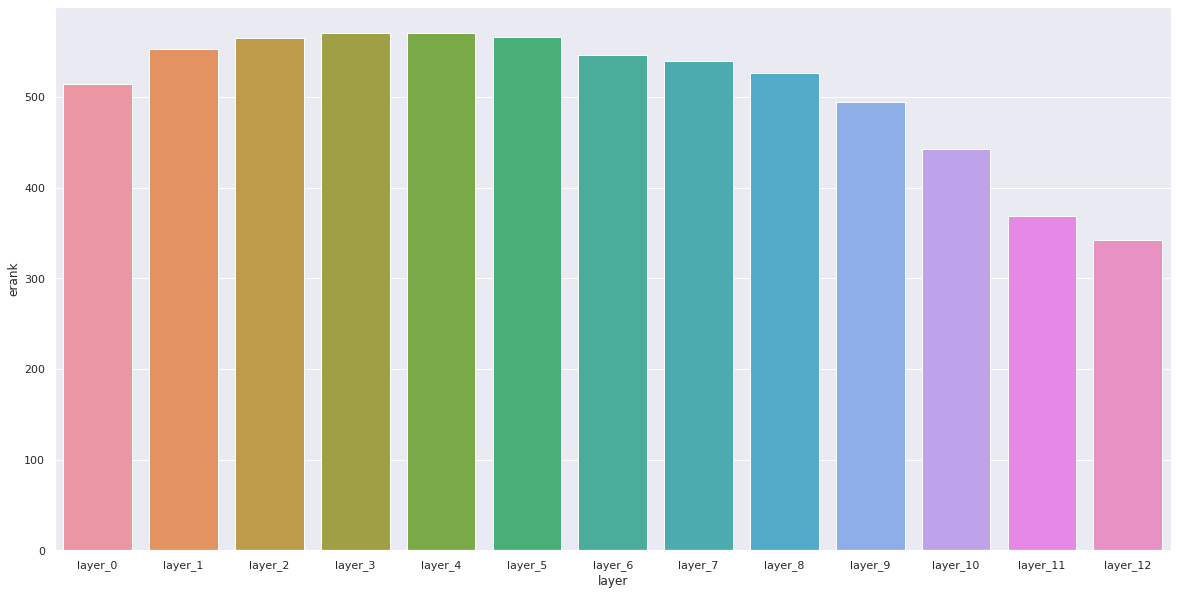

In [40]:
figure = plt.figure(figsize=(20, 10))
df = calculus_erank(dataset=test_dataset_flaubert, type_model="flaubert")
sns.barplot(x="layer", y="erank", data=df)

<AxesSubplot:xlabel='layer', ylabel='erank'>

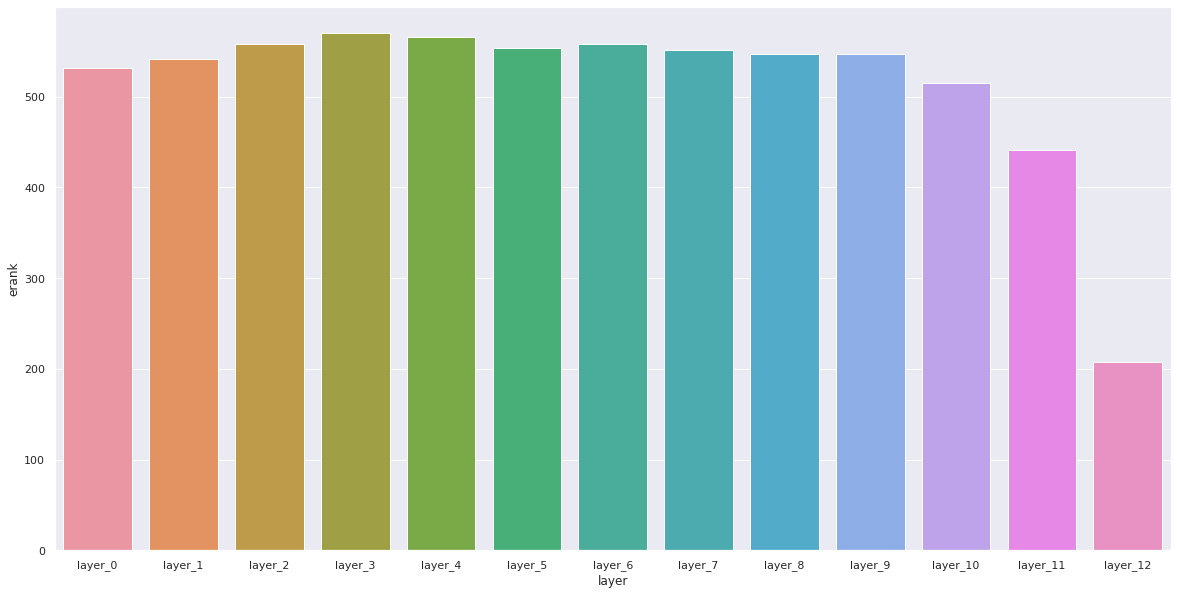

In [41]:
df = calculus_erank(dataset=test_dataset_camembert, type_model="camembert")
figure = plt.figure(figsize=(20, 10))
sns.barplot(x="layer", y="erank", data=df)